<a href="https://colab.research.google.com/github/Rethvik/Book-App/blob/main/Model_1_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
%matplotlib inline
# python libraties
import os, cv2,itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image

# pytorch libraries
import torch
from torch import optim,nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

# sklearn libraries
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ensure results are reproducible
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

# return directory
#print(os.listdir('/kaggle/input/'))

In [11]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.19G/5.20G [00:30<00:00, 217MB/s]
100% 5.20G/5.20G [00:30<00:00, 182MB/s]


In [13]:
ls

kaggle.json  sample_data/  skin-cancer-mnist-ham10000.zip


In [14]:
! unzip skin-cancer-mnist-ham10000.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

# Load data

In [15]:
data_dir = './'
all_image_path = glob(os.path.join(data_dir, '*', '*.jpg'))
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in all_image_path}
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [16]:
def compute_img_mean_std(image_paths):
    """
        computing the mean and std of three channel on the whole dataset,
        first we should normalize the image from 0-255 to 0-1
    """

    img_h, img_w = 224, 224
    imgs = []
    means, stdevs = [], []

    for i in tqdm(range(len(image_paths))):
        img = cv2.imread(image_paths[i])
        img = cv2.resize(img, (img_h, img_w))
        imgs.append(img)

    imgs = np.stack(imgs, axis=3)
    print(imgs.shape)

    imgs = imgs.astype(np.float32) / 255.

    for i in range(3):
        pixels = imgs[:, :, i, :].ravel()  # resize to one row
        means.append(np.mean(pixels))
        stdevs.append(np.std(pixels))

    means.reverse()  # BGR --> RGB
    stdevs.reverse()

    print("normMean = {}".format(means))
    print("normStd = {}".format(stdevs))
    return means,stdevs

In [17]:
# Values stored to save future run time
norm_mean = [0.7630392, 0.5456477, 0.57004845]
norm_std = [0.1409286, 0.15261266, 0.16997074]

In [18]:
df_original = pd.read_csv(os.path.join(data_dir, 'HAM10000_metadata.csv'))
df_original['path'] = df_original['image_id'].map(imageid_path_dict.get)
df_original['cell_type'] = df_original['dx'].map(lesion_type_dict.get)
df_original['cell_type_idx'] = pd.Categorical(df_original['cell_type']).codes
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2


In [19]:
# Determine how many images are associated with each lesion_id
df_undup = df_original.groupby('lesion_id').count()
# Filter out lesion_id's that have only one image associated with it
df_undup = df_undup[df_undup['image_id'] == 1]
df_undup.reset_index(inplace=True)
df_undup.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000001,1,1,1,1,1,1,1,1,1
1,HAM_0000003,1,1,1,1,1,1,1,1,1
2,HAM_0000004,1,1,1,1,1,1,1,1,1
3,HAM_0000007,1,1,1,1,1,1,1,1,1
4,HAM_0000008,1,1,1,1,1,1,1,1,1


In [20]:
# Identify lesion_id's that have duplicate images and those that have only one image.
def get_duplicates(x):
    unique_list = list(df_undup['lesion_id'])
    if x in unique_list:
        return 'unduplicated'
    else:
        return 'duplicated'

# Create a new colum that is a copy of the lesion_id column
df_original['duplicates'] = df_original['lesion_id']
# Apply the function to this new column
df_original['duplicates'] = df_original['duplicates'].apply(get_duplicates)
df_original.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,duplicates
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0027419.jpg,Benign keratosis-like lesions,2,duplicated
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0025030.jpg,Benign keratosis-like lesions,2,duplicated
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0026769.jpg,Benign keratosis-like lesions,2,duplicated
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./ham10000_images_part_1/ISIC_0025661.jpg,Benign keratosis-like lesions,2,duplicated
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./HAM10000_images_part_2/ISIC_0031633.jpg,Benign keratosis-like lesions,2,duplicated


In [21]:
df_original['duplicates'].value_counts()

unduplicated    5514
duplicated      4501
Name: duplicates, dtype: int64

In [22]:
# Filter out images that don't have duplicates
df_undup = df_original[df_original['duplicates'] == 'unduplicated']
df_undup.shape

(5514, 11)

In [23]:
# Create a val set using df as none of these images have augmented duplicates in the train set
y = df_undup['cell_type_idx']
_, df_val = train_test_split(df_undup, test_size=0.2, random_state=101, stratify=y)
df_val.shape

(1103, 11)

In [24]:
df_val['cell_type_idx'].value_counts()

4    883
2     88
6     46
1     35
0     30
5     13
3      8
Name: cell_type_idx, dtype: int64

In [25]:
# This set will be df_original excluding all rows that are in the val set
# This function identifies if an image is part of the train or val set.
def get_val_rows(x):
    # create a list of all the lesion_id's in the val set
    val_list = list(df_val['image_id'])
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'

# Identify train and val rows
# Create a new colum that is a copy of the image_id column
df_original['train_or_val'] = df_original['image_id']
# Apply the function to this new column
df_original['train_or_val'] = df_original['train_or_val'].apply(get_val_rows)
# Filter out training rows
df_train = df_original[df_original['train_or_val'] == 'train']
print(len(df_train))
print(len(df_val))

8912
1103


In [26]:
df_train['cell_type_idx'].value_counts()

4    5822
6    1067
2    1011
1     479
0     297
5     129
3     107
Name: cell_type_idx, dtype: int64

In [27]:
df_val['cell_type'].value_counts()

Melanocytic nevi                  883
Benign keratosis-like lesions      88
dermatofibroma                     46
Basal cell carcinoma               35
Actinic keratoses                  30
Vascular lesions                   13
Dermatofibroma                      8
Name: cell_type, dtype: int64

In [28]:
# Copy fewer class to balance the number of 7 classes
data_aug_rate = [15,10,5,50,0,40,5]
for i in range(7):
    if data_aug_rate[i]:
        df_train=df_train.append([df_train.loc[df_train['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
df_train['cell_type'].value_counts()

Melanocytic nevi                  5822
Dermatofibroma                    5350
dermatofibroma                    5335
Vascular lesions                  5160
Benign keratosis-like lesions     5055
Basal cell carcinoma              4790
Actinic keratoses                 4455
Name: cell_type, dtype: int64

# Split dataset

In [29]:
# Split the test set again in a validation set and a true test set:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [30]:
print(len(df_test))
df_test['cell_type'].value_counts()

552


Melanocytic nevi                  444
Benign keratosis-like lesions      47
dermatofibroma                     20
Basal cell carcinoma               15
Actinic keratoses                  12
Vascular lesions                    8
Dermatofibroma                      6
Name: cell_type, dtype: int64

# Set model

In [31]:
# feature_extract is a boolean that defines finetuning or feature extracting. 
# If feature_extract = False, the model is finetuned and all model parameters are updated. 
# If feature_extract = True, only the last layer parameters are updated, the others remain fixed.
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [32]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18, resnet34, resnet50, resnet101
        """
        model_ft = models.resnet50(pretrained=True)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [33]:
model_name = "resnet"
num_classes = 7
feature_extract = False
# Initialize the model
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
# Define the device:
device = torch.device('cuda:0')
# device = torch.device('cpu') # If using cpu
# Put the model on the device:
model = model_ft.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Data augmentation

In [34]:
# define the transformation of the train images.
train_transform = transforms.Compose([transforms.Resize((input_size,input_size)),transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(20),
                                      transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
                                      transforms.ToTensor(), 
                                      transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the val images.
val_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

# define the transformation of the test images.
test_transform = transforms.Compose([transforms.Resize((input_size,input_size)), 
                                     transforms.ToTensor(),
                                    transforms.Normalize(norm_mean, norm_std)])

In [35]:
# Define a pytorch dataloader for dataset
class HAM10000(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Load data and get label
        X = Image.open(self.df['path'][index])
        y = torch.tensor(int(self.df['cell_type_idx'][index]))

        if self.transform:
            X = self.transform(X)

        return X, y

In [36]:
# Define the training set using the table train_df and using the defined transitions (train_transform)
training_set = HAM10000(df_train, transform=train_transform)
train_loader = DataLoader(training_set, batch_size=32, shuffle=True, num_workers=4)

# Same for the validation set:
validation_set = HAM10000(df_val, transform=train_transform)
val_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=4)

# Same for the test set:
test_set = HAM10000(df_test, transform=train_transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [37]:
# set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss().to(device)

In [38]:
# this function is used during training process, to calculate the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [39]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [40]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader)):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [41]:
epoch_num = 10
best_val_acc = 0
total_loss_val, total_acc_val = [],[]
for epoch in tqdm(range(1, epoch_num+1)):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(val_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

  0%|          | 0/10 [00:00<?, ?it/s]

[epoch 1], [iter 100 / 1124], [train loss 1.64135], [train acc 0.36812]
[epoch 1], [iter 200 / 1124], [train loss 1.48753], [train acc 0.43109]
[epoch 1], [iter 300 / 1124], [train loss 1.40496], [train acc 0.46615]
[epoch 1], [iter 400 / 1124], [train loss 1.33690], [train acc 0.49641]
[epoch 1], [iter 500 / 1124], [train loss 1.28673], [train acc 0.51531]
[epoch 1], [iter 600 / 1124], [train loss 1.24172], [train acc 0.53312]
[epoch 1], [iter 700 / 1124], [train loss 1.20209], [train acc 0.54888]
[epoch 1], [iter 800 / 1124], [train loss 1.16867], [train acc 0.56219]
[epoch 1], [iter 900 / 1124], [train loss 1.13339], [train acc 0.57455]
[epoch 1], [iter 1000 / 1124], [train loss 1.10317], [train acc 0.58650]
[epoch 1], [iter 1100 / 1124], [train loss 1.07606], [train acc 0.59651]



0it [00:00, ?it/s]
1it [00:01,  1.72s/it]
2it [00:01,  1.28it/s]
3it [00:02,  2.01it/s]
4it [00:02,  2.84it/s]
5it [00:03,  1.68it/s]
6it [00:03,  2.34it/s]
7it [00:03,  2.59it/s]
8it [00:03,  2.82it/s]
9it [00:05,  1.57it/s]
10it [00:05,  2.08it/s]
11it [00:05,  2.68it/s]
12it [00:05,  3.39it/s]
13it [00:07,  1.49it/s]
14it [00:07,  2.01it/s]
15it [00:07,  2.62it/s]
16it [00:07,  3.36it/s]
18it [00:07,  2.29it/s]
 10%|█         | 1/10 [09:04<1:21:44, 544.93s/it]

------------------------------------------------------------
[epoch 1], [val loss 0.52868], [val acc 0.81250]
------------------------------------------------------------
*****************************************************
best record: [epoch 1], [val loss 0.52868], [val acc 0.81250]
*****************************************************
[epoch 2], [iter 100 / 1124], [train loss 0.79715], [train acc 0.70031]
[epoch 2], [iter 200 / 1124], [train loss 0.80846], [train acc 0.69563]
[epoch 2], [iter 300 / 1124], [train loss 0.79476], [train acc 0.70385]
[epoch 2], [iter 400 / 1124], [train loss 0.78886], [train acc 0.70586]
[epoch 2], [iter 500 / 1124], [train loss 0.77316], [train acc 0.71150]
[epoch 2], [iter 600 / 1124], [train loss 0.76029], [train acc 0.71703]
[epoch 2], [iter 700 / 1124], [train loss 0.75229], [train acc 0.71969]
[epoch 2], [iter 800 / 1124], [train loss 0.73978], [train acc 0.72488]
[epoch 2], [iter 900 / 1124], [train loss 0.73038], [train acc 0.72792]
[epoch 2], 


0it [00:00, ?it/s]
1it [00:01,  1.82s/it]
2it [00:01,  1.21it/s]
3it [00:02,  1.97it/s]
4it [00:02,  2.86it/s]
5it [00:03,  1.39it/s]
6it [00:03,  1.95it/s]
7it [00:03,  2.59it/s]
8it [00:03,  3.30it/s]
9it [00:05,  1.65it/s]
10it [00:05,  2.15it/s]
11it [00:05,  2.77it/s]
12it [00:05,  3.52it/s]
13it [00:06,  1.68it/s]
14it [00:07,  2.21it/s]
15it [00:07,  2.84it/s]
16it [00:07,  3.57it/s]
18it [00:07,  2.31it/s]
 20%|██        | 2/10 [17:49<1:11:03, 532.94s/it]

------------------------------------------------------------
[epoch 2], [val loss 0.48880], [val acc 0.84375]
------------------------------------------------------------
*****************************************************
best record: [epoch 2], [val loss 0.48880], [val acc 0.84375]
*****************************************************
[epoch 3], [iter 100 / 1124], [train loss 0.65345], [train acc 0.75406]
[epoch 3], [iter 200 / 1124], [train loss 0.63800], [train acc 0.75906]
[epoch 3], [iter 300 / 1124], [train loss 0.62942], [train acc 0.76198]
[epoch 3], [iter 400 / 1124], [train loss 0.62293], [train acc 0.76516]
[epoch 3], [iter 500 / 1124], [train loss 0.61043], [train acc 0.76994]
[epoch 3], [iter 600 / 1124], [train loss 0.60145], [train acc 0.77328]
[epoch 3], [iter 700 / 1124], [train loss 0.59819], [train acc 0.77339]
[epoch 3], [iter 800 / 1124], [train loss 0.59595], [train acc 0.77484]
[epoch 3], [iter 900 / 1124], [train loss 0.59027], [train acc 0.77743]
[epoch 3], 


0it [00:00, ?it/s]
1it [00:01,  1.93s/it]
2it [00:02,  1.15it/s]
3it [00:02,  1.87it/s]
4it [00:02,  2.70it/s]
5it [00:03,  1.34it/s]
6it [00:03,  1.87it/s]
7it [00:03,  2.48it/s]
8it [00:04,  3.23it/s]
9it [00:05,  1.44it/s]
10it [00:05,  1.93it/s]
11it [00:05,  2.49it/s]
12it [00:06,  3.18it/s]
13it [00:07,  1.59it/s]
14it [00:07,  2.11it/s]
15it [00:07,  2.71it/s]
16it [00:07,  3.46it/s]
18it [00:08,  2.16it/s]
 30%|███       | 3/10 [26:57<1:02:59, 539.96s/it]

------------------------------------------------------------
[epoch 3], [val loss 0.46442], [val acc 0.83160]
------------------------------------------------------------
[epoch 4], [iter 100 / 1124], [train loss 0.54202], [train acc 0.79812]
[epoch 4], [iter 200 / 1124], [train loss 0.53255], [train acc 0.79828]
[epoch 4], [iter 300 / 1124], [train loss 0.52893], [train acc 0.79812]
[epoch 4], [iter 400 / 1124], [train loss 0.52617], [train acc 0.79906]
[epoch 4], [iter 500 / 1124], [train loss 0.52480], [train acc 0.80069]
[epoch 4], [iter 600 / 1124], [train loss 0.51607], [train acc 0.80323]
[epoch 4], [iter 700 / 1124], [train loss 0.51635], [train acc 0.80321]
[epoch 4], [iter 800 / 1124], [train loss 0.51046], [train acc 0.80527]
[epoch 4], [iter 900 / 1124], [train loss 0.50605], [train acc 0.80757]
[epoch 4], [iter 1000 / 1124], [train loss 0.50568], [train acc 0.80797]
[epoch 4], [iter 1100 / 1124], [train loss 0.50183], [train acc 0.80932]



0it [00:00, ?it/s]
1it [00:01,  1.98s/it]
2it [00:02,  1.12it/s]
3it [00:02,  1.77it/s]
4it [00:02,  2.52it/s]
5it [00:03,  1.37it/s]
6it [00:03,  1.89it/s]
7it [00:04,  2.47it/s]
8it [00:04,  3.19it/s]
9it [00:05,  1.50it/s]
10it [00:05,  2.01it/s]
11it [00:05,  2.55it/s]
12it [00:06,  3.21it/s]
13it [00:07,  1.49it/s]
14it [00:07,  1.99it/s]
15it [00:07,  2.58it/s]
16it [00:07,  3.29it/s]
18it [00:08,  2.14it/s]
 40%|████      | 4/10 [36:19<54:51, 548.54s/it]  

------------------------------------------------------------
[epoch 4], [val loss 0.39104], [val acc 0.87674]
------------------------------------------------------------
*****************************************************
best record: [epoch 4], [val loss 0.39104], [val acc 0.87674]
*****************************************************
[epoch 5], [iter 100 / 1124], [train loss 0.43266], [train acc 0.83844]
[epoch 5], [iter 200 / 1124], [train loss 0.44636], [train acc 0.83062]
[epoch 5], [iter 300 / 1124], [train loss 0.44426], [train acc 0.83292]
[epoch 5], [iter 400 / 1124], [train loss 0.44289], [train acc 0.83328]
[epoch 5], [iter 500 / 1124], [train loss 0.44590], [train acc 0.83100]
[epoch 5], [iter 600 / 1124], [train loss 0.44643], [train acc 0.83130]
[epoch 5], [iter 700 / 1124], [train loss 0.44707], [train acc 0.83170]
[epoch 5], [iter 800 / 1124], [train loss 0.44489], [train acc 0.83219]
[epoch 5], [iter 900 / 1124], [train loss 0.44108], [train acc 0.83292]
[epoch 5], 


0it [00:00, ?it/s]
1it [00:01,  1.75s/it]
2it [00:02,  1.10it/s]
3it [00:02,  1.76it/s]
4it [00:02,  2.56it/s]
5it [00:03,  1.56it/s]
6it [00:03,  1.63it/s]
7it [00:04,  2.18it/s]
8it [00:04,  2.85it/s]
9it [00:05,  1.64it/s]
10it [00:05,  1.83it/s]
11it [00:05,  2.38it/s]
12it [00:06,  3.04it/s]
13it [00:07,  1.76it/s]
14it [00:07,  1.90it/s]
15it [00:07,  2.47it/s]
16it [00:07,  3.14it/s]
18it [00:08,  2.15it/s]
 50%|█████     | 5/10 [45:47<46:17, 555.59s/it]

------------------------------------------------------------
[epoch 5], [val loss 0.43292], [val acc 0.84722]
------------------------------------------------------------
[epoch 6], [iter 100 / 1124], [train loss 0.41479], [train acc 0.83875]
[epoch 6], [iter 200 / 1124], [train loss 0.41975], [train acc 0.83578]
[epoch 6], [iter 300 / 1124], [train loss 0.41433], [train acc 0.84062]
[epoch 6], [iter 400 / 1124], [train loss 0.40504], [train acc 0.84445]
[epoch 6], [iter 500 / 1124], [train loss 0.39705], [train acc 0.84625]
[epoch 6], [iter 600 / 1124], [train loss 0.39525], [train acc 0.84474]
[epoch 6], [iter 700 / 1124], [train loss 0.39363], [train acc 0.84625]
[epoch 6], [iter 800 / 1124], [train loss 0.39266], [train acc 0.84621]
[epoch 6], [iter 900 / 1124], [train loss 0.39150], [train acc 0.84684]
[epoch 6], [iter 1000 / 1124], [train loss 0.38656], [train acc 0.84966]
[epoch 6], [iter 1100 / 1124], [train loss 0.38453], [train acc 0.85034]



0it [00:00, ?it/s]
1it [00:01,  1.81s/it]
2it [00:02,  1.18it/s]
3it [00:02,  1.89it/s]
4it [00:02,  2.71it/s]
5it [00:03,  1.34it/s]
6it [00:03,  1.87it/s]
7it [00:03,  2.47it/s]
8it [00:04,  3.16it/s]
9it [00:05,  1.49it/s]
10it [00:05,  1.99it/s]
11it [00:05,  2.53it/s]
12it [00:05,  3.18it/s]
13it [00:07,  1.66it/s]
14it [00:07,  2.04it/s]
15it [00:07,  2.64it/s]
16it [00:07,  3.27it/s]
18it [00:08,  2.15it/s]
 60%|██████    | 6/10 [55:09<37:11, 557.80s/it]

------------------------------------------------------------
[epoch 6], [val loss 0.55402], [val acc 0.80556]
------------------------------------------------------------
[epoch 7], [iter 100 / 1124], [train loss 0.33506], [train acc 0.86531]
[epoch 7], [iter 200 / 1124], [train loss 0.34925], [train acc 0.86844]
[epoch 7], [iter 300 / 1124], [train loss 0.35145], [train acc 0.86750]
[epoch 7], [iter 400 / 1124], [train loss 0.34999], [train acc 0.86695]
[epoch 7], [iter 500 / 1124], [train loss 0.34603], [train acc 0.86731]
[epoch 7], [iter 600 / 1124], [train loss 0.34576], [train acc 0.86729]
[epoch 7], [iter 700 / 1124], [train loss 0.34332], [train acc 0.86786]
[epoch 7], [iter 800 / 1124], [train loss 0.34069], [train acc 0.86867]
[epoch 7], [iter 900 / 1124], [train loss 0.34090], [train acc 0.86892]
[epoch 7], [iter 1000 / 1124], [train loss 0.33875], [train acc 0.87034]
[epoch 7], [iter 1100 / 1124], [train loss 0.33582], [train acc 0.87179]



0it [00:00, ?it/s]
1it [00:01,  1.91s/it]
2it [00:02,  1.16it/s]
3it [00:02,  1.87it/s]
4it [00:02,  2.73it/s]
5it [00:03,  1.32it/s]
6it [00:03,  1.85it/s]
7it [00:04,  2.44it/s]
8it [00:04,  3.15it/s]
9it [00:05,  1.47it/s]
10it [00:05,  1.97it/s]
11it [00:05,  2.54it/s]
12it [00:05,  3.21it/s]
13it [00:07,  1.61it/s]
14it [00:07,  2.15it/s]
15it [00:07,  2.77it/s]
16it [00:07,  3.53it/s]
18it [00:08,  2.19it/s]
 70%|███████   | 7/10 [1:04:26<27:52, 557.60s/it]

------------------------------------------------------------
[epoch 7], [val loss 0.51326], [val acc 0.83160]
------------------------------------------------------------
[epoch 8], [iter 100 / 1124], [train loss 0.29879], [train acc 0.87906]
[epoch 8], [iter 200 / 1124], [train loss 0.30743], [train acc 0.87813]
[epoch 8], [iter 300 / 1124], [train loss 0.31142], [train acc 0.87865]
[epoch 8], [iter 400 / 1124], [train loss 0.31080], [train acc 0.88180]
[epoch 8], [iter 500 / 1124], [train loss 0.31231], [train acc 0.88087]
[epoch 8], [iter 600 / 1124], [train loss 0.31085], [train acc 0.88094]
[epoch 8], [iter 700 / 1124], [train loss 0.30712], [train acc 0.88263]
[epoch 8], [iter 800 / 1124], [train loss 0.30663], [train acc 0.88273]
[epoch 8], [iter 900 / 1124], [train loss 0.30511], [train acc 0.88337]
[epoch 8], [iter 1000 / 1124], [train loss 0.30327], [train acc 0.88384]
[epoch 8], [iter 1100 / 1124], [train loss 0.30269], [train acc 0.88426]



0it [00:00, ?it/s]
1it [00:01,  1.73s/it]
2it [00:01,  1.23it/s]
3it [00:02,  1.99it/s]
4it [00:02,  2.87it/s]
5it [00:03,  1.46it/s]
6it [00:03,  1.90it/s]
7it [00:03,  2.49it/s]
8it [00:03,  3.19it/s]
9it [00:05,  1.64it/s]
10it [00:05,  2.10it/s]
11it [00:05,  2.40it/s]
12it [00:05,  3.11it/s]
13it [00:06,  1.74it/s]
14it [00:07,  2.13it/s]
15it [00:07,  2.42it/s]
16it [00:07,  3.09it/s]
18it [00:08,  2.24it/s]
 80%|████████  | 8/10 [1:13:30<18:26, 553.14s/it]

------------------------------------------------------------
[epoch 8], [val loss 0.38152], [val acc 0.87326]
------------------------------------------------------------
[epoch 9], [iter 100 / 1124], [train loss 0.28322], [train acc 0.89812]
[epoch 9], [iter 200 / 1124], [train loss 0.28052], [train acc 0.89172]
[epoch 9], [iter 300 / 1124], [train loss 0.28064], [train acc 0.88990]
[epoch 9], [iter 400 / 1124], [train loss 0.27532], [train acc 0.89133]
[epoch 9], [iter 500 / 1124], [train loss 0.27888], [train acc 0.89144]
[epoch 9], [iter 600 / 1124], [train loss 0.27626], [train acc 0.89370]
[epoch 9], [iter 700 / 1124], [train loss 0.27873], [train acc 0.89295]
[epoch 9], [iter 800 / 1124], [train loss 0.28131], [train acc 0.89199]
[epoch 9], [iter 900 / 1124], [train loss 0.27859], [train acc 0.89299]
[epoch 9], [iter 1000 / 1124], [train loss 0.27752], [train acc 0.89372]
[epoch 9], [iter 1100 / 1124], [train loss 0.27627], [train acc 0.89429]



0it [00:00, ?it/s]
1it [00:01,  1.92s/it]
2it [00:02,  1.14it/s]
3it [00:02,  1.80it/s]
4it [00:02,  2.65it/s]
5it [00:03,  1.38it/s]
6it [00:03,  1.92it/s]
7it [00:03,  2.54it/s]
8it [00:04,  3.27it/s]
9it [00:05,  1.70it/s]
10it [00:05,  1.97it/s]
11it [00:05,  2.55it/s]
12it [00:05,  3.19it/s]
13it [00:07,  1.70it/s]
14it [00:07,  2.10it/s]
15it [00:07,  2.71it/s]
16it [00:07,  3.46it/s]
18it [00:08,  2.23it/s]
 90%|█████████ | 9/10 [1:22:35<09:10, 550.66s/it]

------------------------------------------------------------
[epoch 9], [val loss 0.45719], [val acc 0.85764]
------------------------------------------------------------
[epoch 10], [iter 100 / 1124], [train loss 0.24591], [train acc 0.90844]
[epoch 10], [iter 200 / 1124], [train loss 0.24053], [train acc 0.90953]
[epoch 10], [iter 300 / 1124], [train loss 0.24772], [train acc 0.90677]
[epoch 10], [iter 400 / 1124], [train loss 0.23971], [train acc 0.90906]
[epoch 10], [iter 500 / 1124], [train loss 0.24318], [train acc 0.90838]
[epoch 10], [iter 600 / 1124], [train loss 0.24753], [train acc 0.90687]
[epoch 10], [iter 700 / 1124], [train loss 0.24969], [train acc 0.90549]
[epoch 10], [iter 800 / 1124], [train loss 0.24781], [train acc 0.90664]
[epoch 10], [iter 900 / 1124], [train loss 0.24520], [train acc 0.90795]
[epoch 10], [iter 1000 / 1124], [train loss 0.24160], [train acc 0.90941]
[epoch 10], [iter 1100 / 1124], [train loss 0.24121], [train acc 0.90940]



0it [00:00, ?it/s]
1it [00:01,  1.78s/it]
2it [00:01,  1.20it/s]
3it [00:02,  1.93it/s]
4it [00:02,  2.80it/s]
5it [00:03,  1.32it/s]
6it [00:04,  1.62it/s]
7it [00:04,  2.15it/s]
8it [00:04,  2.80it/s]
9it [00:06,  1.04it/s]
10it [00:06,  1.41it/s]
11it [00:06,  1.85it/s]
12it [00:07,  2.41it/s]
13it [00:08,  1.45it/s]
14it [00:08,  1.95it/s]
15it [00:08,  2.53it/s]
16it [00:08,  3.24it/s]
18it [00:09,  1.92it/s]
100%|██████████| 10/10 [1:31:40<00:00, 550.07s/it]

------------------------------------------------------------
[epoch 10], [val loss 0.36522], [val acc 0.88368]
------------------------------------------------------------
*****************************************************
best record: [epoch 10], [val loss 0.36522], [val acc 0.88368]
*****************************************************


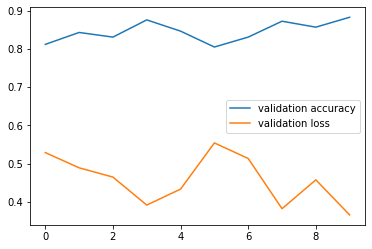

In [42]:
fig = plt.figure(num = 1)
fig2 = fig.add_subplot(1,1,1)
fig2.plot(total_acc_val, label = 'validation accuracy')
fig2.plot(total_loss_val, label = 'validation loss')

plt.legend()
plt.show()

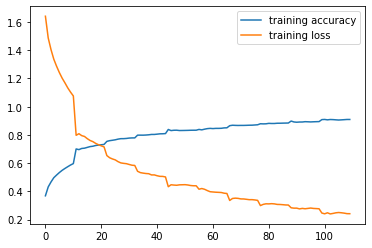

In [43]:
fig = plt.figure(num=1)
fig1 = fig.add_subplot(1,1,1)
fig1.plot(total_acc_train, label = 'training accuracy')
fig1.plot(total_loss_train, label = 'training loss')

plt.legend()
plt.show()

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

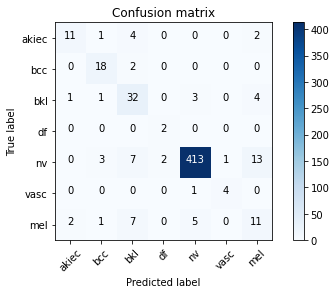

In [45]:
# Validation data evaluation

model.eval()
y_label = []
y_predict = []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        y_label.extend(labels.cpu().numpy())
        y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_label, y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


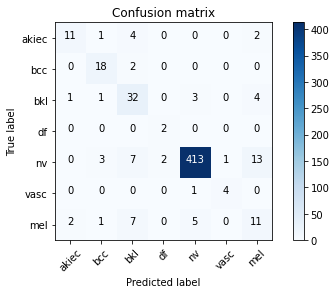

In [46]:
# Test data evaluation

model.eval()
test_y_label = []
test_y_predict = []
with torch.no_grad():
    for i, data in enumerate(test_loader):
        images, labels = data
        N = images.size(0)
        images = Variable(images).to(device)
        outputs = model(images)
        prediction = outputs.max(1, keepdim=True)[1]
        test_y_label.extend(labels.cpu().numpy())
        test_y_predict.extend(np.squeeze(prediction.cpu().numpy().T))

# compute the confusion matrix
confusion_mtx_test = confusion_matrix(test_y_label, test_y_predict)
# plot the confusion matrix
plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc','mel']
plot_confusion_matrix(confusion_mtx, plot_labels)

In [47]:
# Generate a validation classification report
report = classification_report(y_label, y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.79      0.61      0.69        18
         bcc       0.75      0.90      0.82        20
         bkl       0.62      0.78      0.69        41
          df       0.50      1.00      0.67         2
          nv       0.98      0.94      0.96       439
        vasc       0.80      0.80      0.80         5
         mel       0.37      0.42      0.39        26

    accuracy                           0.89       551
   macro avg       0.69      0.78      0.72       551
weighted avg       0.90      0.89      0.90       551



In [48]:
# Generate a test classification report
report = classification_report(test_y_label, test_y_predict, target_names=plot_labels)
print(report)

              precision    recall  f1-score   support

       akiec       0.40      0.67      0.50        12
         bcc       0.71      0.67      0.69        15
         bkl       0.60      0.64      0.62        47
          df       0.83      0.83      0.83         6
          nv       0.98      0.93      0.95       444
        vasc       0.78      0.88      0.82         8
         mel       0.34      0.55      0.42        20

    accuracy                           0.88       552
   macro avg       0.66      0.74      0.69       552
weighted avg       0.90      0.88      0.89       552



Text(0, 0.5, 'Fraction classified incorrectly')

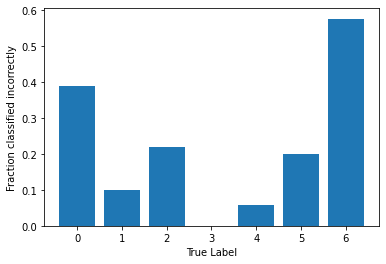

In [49]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

Text(0, 0.5, 'Fraction classified incorrectly')

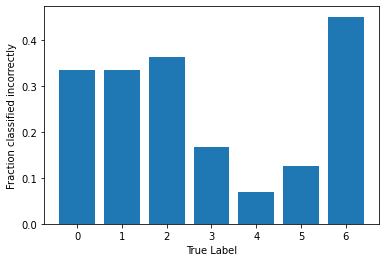

In [50]:
label_frac_error = 1 - np.diag(confusion_mtx_test) / np.sum(confusion_mtx_test, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')